# Documentation of particles 'stuck' on boundaries
In some Parcels simulations, particles end up moving onto parts of the grid where the velocity field is not defined, such as for example onto land. In this tutorial we look at how this depends on the grid structure. 

**Short conclusion: Particles can get stuck on Arakawa A grids and B grids but should not get stuck on C grids.**

This tutorial first looks at how velocity fields are structured and what that means for where the ocean-land boundaries are located. Then we look at how particles may end up getting 'stuck' on these boundaries. How to make these particles become 'unstuck' again in Parcels will be discussed in another notebook.

* [Introduction](#Introduction)
* [A grid interpolated velocity fields - SMOC](#1.-A-grids)
* [C grid numerical model - NEMO](#2.-C-grids)
* [B grids](#3.-B-grids)
* [Diffusion](#4.-Diffusion)

## Introduction
Parcels can handle several different types of velocity fields, which makes it widely applicable. This also means that the underlying code and therefore the accuracy of the calculated trajectories can differ, depending on the velocity data input. Even when Parcels runs smoothly with the velocity fields you use, it is good to realize how your velocity fields are structured and how those velocities are generated in the first place. 

Horizontal velocity data may be structured on a staggered (Arakawa-C) or unstaggered grid (Arakawa-A). The implementation of these grids is covered in [this tutorial](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/documentation_indexing.ipynb).

The source of your velocity data will influence how accurate and physically consistent parcels can calculate trajectories. Common sources are **numerical models and data assimilation products**, **interpolations** of those products or **discrete observations**. The staggering of variables determines how the ocean-land boundaries are defined in models and how their boundary conditions can be satisfied. The Parcels interpolation scheme differs per grid configuration and makes some underlying assumptions that determine the trajectory within a grid cell. Whether the source of your velocity data has physically consistent boundary conditions and how well these align with the assumptions made in Parcels determines how accurately the trajectories move within grid cells. This is especially important near ocean-land boundaries, where particles may end up 'stuck' on land. 

Here we will look at two examples of velocity fields in parcels. We visualize the structure of the velocity field, briefly discuss the Parcels implementation and look at how particles get stuck. Then we shortly discuss Arakawa B grids and additional sources of movement that may not respect the ocean-land boundary, such as particle diffusion using a random walk.

In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, Variable, Field
from glob import glob

import numpy as np
import xarray as xr
from datetime import timedelta as delta
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import cmocean
from copy import copy
from scipy import interpolate
import math
from IPython.display import Image

INFO: Compiled ParcelsRandom ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\libparcels_random_31247341-36d2-4e10-97d4-07551f2eb57f.so


### 1. A grids
Arakawa A grids are unstaggered grids where the velocities $u$, $v$ (and $w$), pressure and other tracers are defined at the same position (on so-called nodes). In numerical models, these nodes can be located **at the corner _or_ at the center of the grid cells**. This means that the cell boundaries, and therefore the solid-fluid boundaries can either be located at the nodes (**figure 1A**) or at 0.5 dx distance from the nodes (**figure 1B**) respectively.

Many ocean models natively run on a C grid, because boundary conditions are easier to implement there (see [C grid](#C-grids)). Sometimes, the C-grid output of these models is interpolated onto an A grid. This is the case for all(?) the data available from [CMEMS](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=GLOBAL_ANALYSIS_FORECAST_PHY_001_024), which provide the data on a rectilinear A grid velocity field. 

To visualize this, in **figure 1** we show the nodes and cells of a coastal region. The ocean cells and nodes are in red and the land cells and nodes are in white.

In [2]:
# --------- Open dataset ---------
SMOCfile = 'SMOC_20190704_R20190705.nc'
SMOCfiles = ['SMOC_20190704_R20190705.nc','SMOC_20190705_R20190706.nc','SMOC_20190706_R20190707.nc','SMOC_20190707_R20190708.nc', 'SMOC_20190708_R20190709.nc']
flowdata_SMOC = xr.open_dataset(SMOCfile)


# --------- Define meshgrid coordinates to plot velocity field with matplotlib pcolormesh ---------
dlon = flowdata_SMOC['longitude'][1]-flowdata_SMOC['longitude'][0] # 1/12 degree
dlat = flowdata_SMOC['latitude'][1]-flowdata_SMOC['latitude'][0]   # 1/12 degree

# Outside corner coordinates - coordinates + 0.5 dx
x_outcorners,y_outcorners = np.meshgrid(np.append((flowdata_SMOC['longitude']-0.5*dlon),(flowdata_SMOC['longitude'][-1]+0.5*dlon)),
                np.append((flowdata_SMOC['latitude']-0.5*dlat),(flowdata_SMOC['latitude'][-1]+0.5*dlat)))

# Inside corner coordinates - coordinates + 0.5 dx - needed to plot cells inbetween velocity field nodes 
x_incorners,y_incorners = np.meshgrid((flowdata_SMOC['longitude']+0.5*dlon)[:-1],
                (flowdata_SMOC['latitude']+0.5*dlat)[:-1])

# Center coordinates
x_centers, y_centers = np.meshgrid(flowdata_SMOC['longitude'],
                flowdata_SMOC['latitude'])


# --------- Velocity fields ---------
cells = np.zeros((len(flowdata_SMOC['latitude']),len(flowdata_SMOC['longitude']))) # Empty cells between coordinate nodes - essentially on inside corners

umask = np.ma.masked_invalid(flowdata_SMOC['uo'][0,0])                                 # Masking the flowfield where U = NaN

u_zeros = np.nan_to_num(flowdata_SMOC['uo'][0,0])                                      # Velocity field with NaN -> zero to be able to use in interp2d
fu = interpolate.interp2d(flowdata_SMOC['longitude'],flowdata_SMOC['latitude'],u_zeros) # Interpolator U

u_corners = fu(x_incorners[0,:],y_incorners[:,0])                                                   # Velocity field interpolated on the inside corners

udmask = np.ma.masked_values(u_corners,0)                                                          # Masking the interpolated flowfield where U = 0

# To interpolate single particle velocity later
v_zeros = np.nan_to_num(flowdata_SMOC['vo'][0,0])                                       # Velocity field with NaN -> zero to be able to use in interp2d
fv = interpolate.interp2d(flowdata_SMOC['longitude'],flowdata_SMOC['latitude'],v_zeros) # Interpolator V

# --------- Plotting domain ---------
lonminx = 2100
lonmaxx = 2500
latminx = 1300
latmaxx = 1750

SMOC_U = flowdata_SMOC['uo'][0,0,latminx:latmaxx,lonminx:lonmaxx].fillna(0)                     # Selected velocity domain to plot
SMOC_V = flowdata_SMOC['vo'][0,0,latminx:latmaxx,lonminx:lonmaxx].fillna(0)                     # Selected velocity domain to plot

### Create seethrough colormap to show different grid interpretations
cmap = plt.get_cmap('Blues')
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = 0                  # set alpha to zero
my_cmap = ListedColormap(my_cmap)

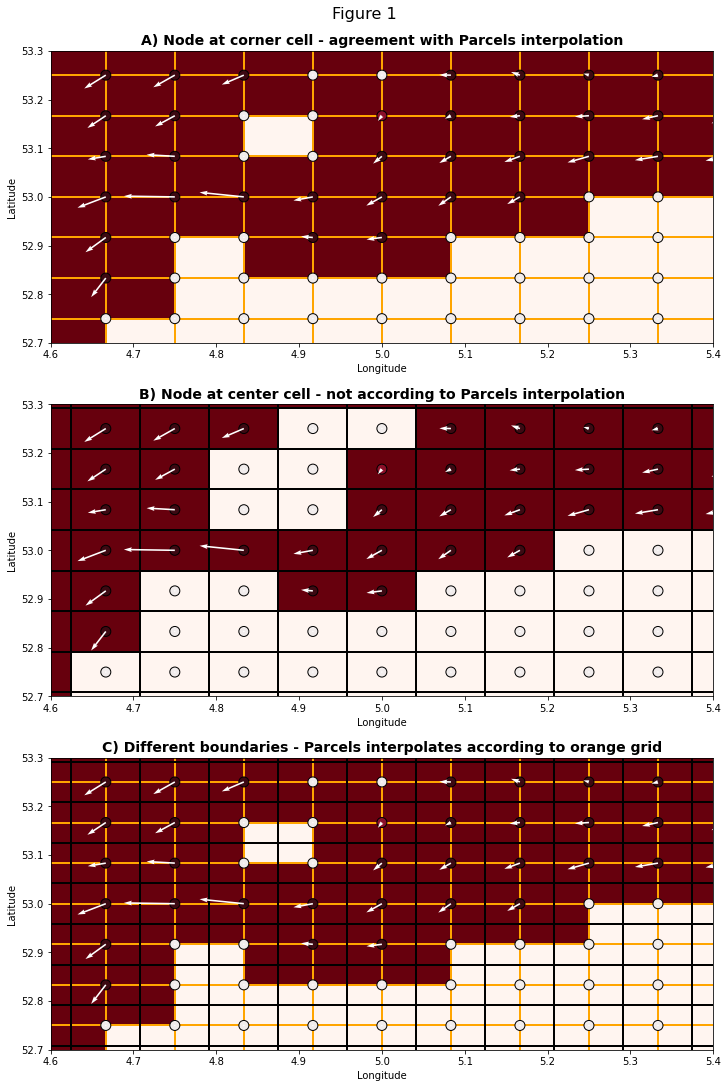

In [3]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,15),constrained_layout=True)
fig.suptitle('Figure 1', fontsize=16)

ax1.set_xlim(4.6,5.4)
ax1.set_ylim(52.7,53.3)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('A) Node at corner cell - agreement with Parcels interpolation', fontsize=14, fontweight = 'bold')
ax1.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange')
ax1.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=100,c=SMOC_U,cmap='cmo.balance_r',vmin=-0.05,vmax=0.05,edgecolors='k')
ax1.quiver(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],SMOC_U,SMOC_V,angles='xy', scale_units='xy', scale=8, color='w',edgecolor='k')

ax2.set_xlim(4.6,5.4)
ax2.set_ylim(52.7,53.3)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('B) Node at center cell - not according to Parcels interpolation', fontsize=14, fontweight = 'bold')
ax2.pcolormesh(x_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k',linewidth=1)
ax2.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=100,c=SMOC_U,cmap='cmo.balance_r',vmin=-0.05,vmax=0.05,edgecolors='k')
ax2.quiver(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],SMOC_U,SMOC_V,angles='xy', scale_units='xy', scale=8, color='w',edgecolor='k')

ax3.set_xlim(4.6,5.4)
ax3.set_ylim(52.7,53.3)
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('C) Different boundaries - Parcels interpolates according to orange grid', fontsize=14, fontweight = 'bold')
ax3.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange')
ax3.pcolormesh(x_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],cells[latminx:latmaxx,lonminx:lonmaxx],cmap=my_cmap,edgecolors='black')
ax3.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=100,c=SMOC_U,cmap='cmo.balance_r',vmin=-0.05,vmax=0.05,edgecolors='k')
ax3.quiver(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],SMOC_U,SMOC_V,angles='xy', scale_units='xy', scale=8, color='w',edgecolor='k')


**Figure 1** shows how *land* grid points and boundaries can be interpreted, depending on whether you assume a grid node is at the center or corner of a cell. When they are at the corner of a cell, boundaries are interpreted as the edges between two nodes. This is especially visible in the upper center of the figures, where the white nodes with surrounding ocean can be assumed to only have a line of *land* between them (**figure 1A**), or as entire *land* cells (**figure 1B**).

#### 1.1 Parcels bilinear interpolation
On Arakawa A grids, Parcels uses a simple bilinear interpolation to find the particle velocity at a specific location in a cell. It finds the four nearest velocity components in a 2D field and interpolates between those. This means that the velocity field is essentially divided into cells by parcels as in **figure 1A**. The boundaries of cells in this case are located between the nodes of the velocity field and therefore the ocean-land boundary lies in between the nodes of the land. Since both velocity components are defined at all four corner nodes, they equally persist in the limit toward the boundary as they go to zero.

In **figure 2**, we zoom on a cell with the velocities at the nodes and an interpolation point shown in cyan. You can see how boundaries are 'interpreted' by Parcels' bilinear interpolation. Given a small enough `dt`, particle trajectories will not cross any lines between two white (land) nodes. This means that particle trajectories will not move onto land. They can however keep moving toward the boundary and essentially get stuck once they come really close, as we will see in the following section.

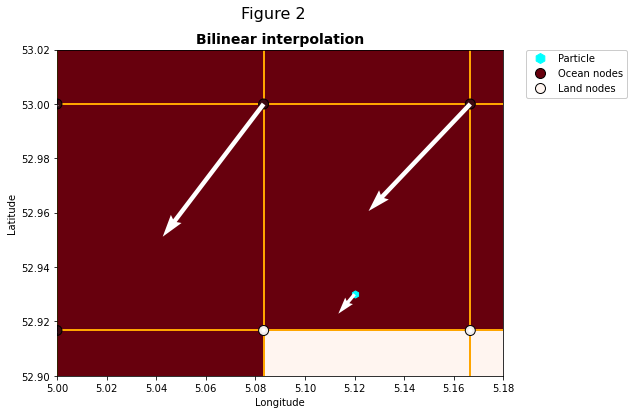

In [4]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Figure 2', fontsize=16)
ax=plt.axes()

ax.set_xlim(5.0,5.18)
ax.set_ylim(52.9,53.02)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Bilinear interpolation', fontsize=14, fontweight = 'bold')
ax.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange')
ax.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=100,c=SMOC_U,cmap='cmo.balance_r',vmin=-0.05,vmax=0.05,edgecolors='k')
ax.quiver(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],SMOC_U,SMOC_V,angles='xy', scale_units='xy', scale=3, color='w',width=0.01)

plon = 5.12
plat = 52.93
pU = fu(plon,plat)
pV = fv(plon,plat)
ax.scatter(plon,plat,s=50, color='cyan',marker='h')
ax.quiver(plon,plat,pU,pV,angles='xy', scale_units='xy', scale=3, color='w')

color_land = copy(plt.get_cmap('Reds'))(0)
color_ocean = copy(plt.get_cmap('Reds'))(256)

custom_lines = [Line2D([0], [0], c='cyan', marker='h', markersize=10, lw=0),
                Line2D([0], [0], c = color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax.legend(custom_lines, ['Particle', 'Ocean nodes', 'Land nodes'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,framealpha=1)

#### 1.2 How do particles get stuck?
Here we create a parcels simulation of trajectories of particles released near and on the *land* cells in the velocity field and see how the bilinear interpolation causes particles to get stuck.

In [5]:
SMOCfile = 'SMOC_201907*.nc'
filenames = {'U': SMOCfile,
             'V': SMOCfile}

variables = {'U': 'uo',
             'V': 'vo'}

dimensions = {'U': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'},
              'V': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'}}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

npart = 3  # number of particles to be released
lon = np.linspace(7, 7.2, npart, dtype=np.float32)
lat = np.linspace(53.45, 53.6, npart, dtype=np.float32)
lons, lats = np.meshgrid(lon,lat)
time = np.zeros(lons.size)

pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats, time=time)

kernels = pset.Kernel(AdvectionRK4)

output_file = pset.ParticleFile(name="SMOC.nc", outputdt=delta(hours=1))

pset.execute(kernels, runtime=delta(hours=119), dt=delta(minutes=12),
             output_file=output_file)
output_file.close()  # export the trajectory data to a netcdf file

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\libd28c2629ad5d7888adaf60f5801f1dee_0.dll
INFO: Temporary output files are stored in out-NALYDQUF.
INFO: You can use "parcels_convert_npydir_to_netcdf out-NALYDQUF" to convert these to a NetCDF file during the run.
100% (428400.0 of 428400.0) |############| Elapsed Time: 0:01:23 Time:  0:01:23


Particles moving toward the boundary will keep slowing down as long as the cross-boundary component of one of the 4 nearest velocity vectors is directed toward the boundary. The distance traveled each `dt` will decrease to unrealistic values in the absence of local forces directing the flow along the boundary. If we define a particle to be stuck when it moves less than approximately 1 meter every hour, we can see how particles get stuck on the model boundary.

In [6]:
ds_SMOC = xr.open_dataset('SMOC.nc')

In [7]:
# Calculating when a particle is stuck
pdx = np.diff(ds_SMOC['lon'],axis=1,prepend=0)
pdy = np.diff(ds_SMOC['lat'],axis=1,prepend=0)
distance = np.sqrt(np.square(pdx)+np.square(pdy)) # approximation of the distance travelled
stuck = distance<1e-5 # [degrees] 1e-5 degrees ~~ 1 m in dt = 1 hour.

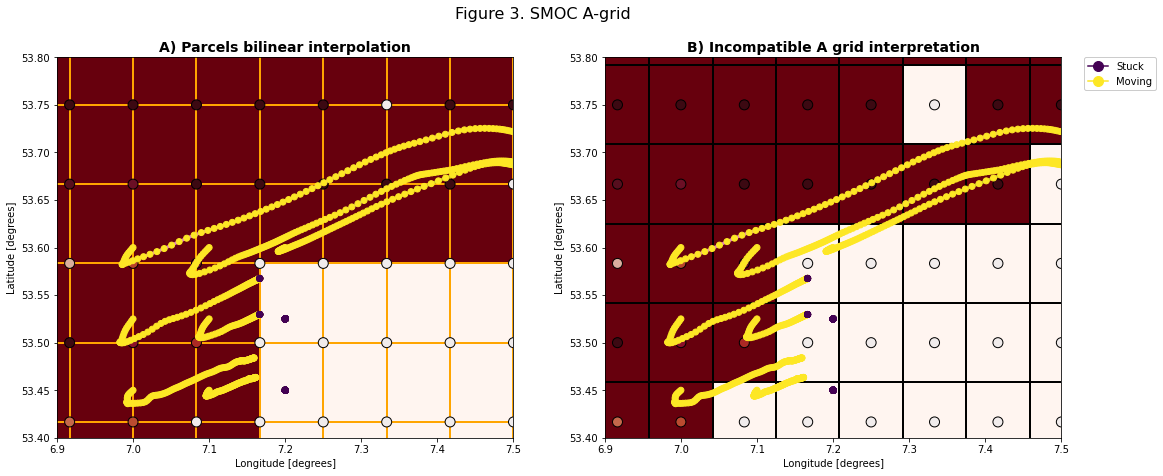

In [8]:
fig = plt.figure(figsize=(18,7))
fig.suptitle('Figure 3. SMOC A-grid', fontsize=16)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_title('A) Parcels bilinear interpolation', fontsize=14, fontweight = 'bold')
ax1.set_xlim(6.9, 7.5)
ax1.set_ylim(53.4, 53.8)

ax1.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange')
ax1.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=100,c=SMOC_U,cmap='cmo.balance_r',vmin=-0.05,vmax=0.05,edgecolors='k')
ax1.plot(ds_SMOC['lon'].T, ds_SMOC['lat'].T,linewidth=3, zorder=1)
ax1.scatter(ds_SMOC['lon'], ds_SMOC['lat'], c= stuck, cmap='viridis_r', zorder=2)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_ylabel('Latitude [degrees]')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_title('B) Incompatible A grid interpretation', fontsize=14, fontweight = 'bold')
ax2.set_xlim(6.9, 7.5)
ax2.set_ylim(53.4, 53.8)

ax2.pcolormesh(x_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k',linewidth=1)
ax2.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=100,c=SMOC_U,cmap='cmo.balance_r',vmin=-0.05,vmax=0.05,edgecolors='k')
ax2.plot(ds_SMOC['lon'].T, ds_SMOC['lat'].T,linewidth=3, zorder=1)
ax2.scatter(ds_SMOC['lon'], ds_SMOC['lat'], c=stuck, cmap='viridis_r', zorder=2)

color_stuck = copy(plt.get_cmap('viridis'))(0)
color_moving = copy(plt.get_cmap('viridis'))(256)
custom_lines = [Line2D([0], [0], c = color_stuck, marker='o', markersize=10),
                Line2D([0], [0], c = color_moving, marker='o', markersize=10)]
ax2.legend(custom_lines, ['Stuck', 'Moving'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,framealpha=1)
plt.show()

In **figure 3A** you can see how particles released in a 3x3 grid keep moving toward the boundary between two *land* nodes. The ratio of the $u$ and $v$ components stays at a similar value due to both being linearly interpolated to zero at the boundary. Note that the interpretation of nodes at the center of grid cells (**figure 3B**) is clearly incompatible with Parcels interpolation.

If we look at the distance traveled each timestep (**figure 4**), we can see that the particles take smaller and smaller steps as they approach the ocean-land boundary. At this scale, a bilinear interpolation of the model results in unrealistic behavior.

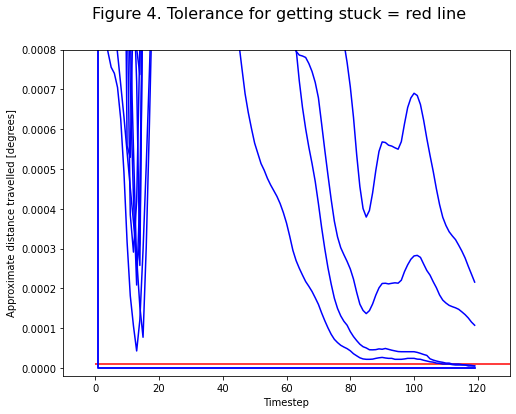

In [9]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Figure 4. Tolerance for getting stuck = red line', fontsize=16)
ax=plt.axes()

ax.plot(distance.T, color='b')
ax.hlines(1e-5,0,130, color='r')
ax.set_ylabel('Approximate distance travelled [degrees]')
ax.set_xlabel('Timestep')
ax.set_ylim(-0.00002,0.0008)
ax.set_xlim(-10, 130)
custom_lines = [Line2D([0], [0], c = 'b'),
                Line2D([0], [0], c = 'r')]
plt.show()

### 2. C grids

On staggered grids, different types of boundary conditions can be satisfied simultaneously. On a C-grid, the velocities are defined on the cell-edges normal to the velocity-component and pressure, temperature and tracers are defined at the cell centers. This way, a [Dirichlet boundary condition](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition) can be used for the velocities, while a [Neumann boundary condition](https://en.wikipedia.org/wiki/Neumann_boundary_condition) can be satisfied for the gradient of pressure. 

Here we investigate how Parcels interprets the the boundaries on a C grid. For background information, see [Delanmeter & Van Sebille (2019)](https://gmd.copernicus.org/articles/12/3571/2019/). First we show how the velocities are staggered and how the velocity input necessary to create a `FieldSet` results in the definition of boundaries in Parcels. This example uses a NEMO dataset but many of the relevant C grid assumptions are similar in other models, such as MITgcm.

In [10]:
cufields = xr.open_dataset('NemoNorthSeaORCA025-N006_data/ORCA025-N06_20000104d05U.nc')
cvfields = xr.open_dataset('NemoNorthSeaORCA025-N006_data/ORCA025-N06_20000104d05V.nc')

xu_corners, yu_corners = np.meshgrid(np.arange(cufields['x'].values[0], cufields['x'].values[-1]+1, 1),
                np.arange(cufields['y'].values[0]-0.5, cufields['y'].values[-1]+0.5, 1))
xv_corners, yv_corners = np.meshgrid(np.arange(cvfields['x'].values[0]-0.5, cvfields['x'].values[-1]+0.5, 1),
                np.arange(cvfields['y'].values[0], cvfields['y'].values[-1]+1, 1))
cx_centers, cy_centers = np.meshgrid(np.arange(cvfields['x'].values[0]-0.5, cvfields['x'].values[-1]+1.5, 1),
                np.arange(cvfields['y'].values[0]-0.5, cvfields['y'].values[-1]+1.5, 1))
fx_corners, fy_corners = np.meshgrid(np.arange(cufields['x'].values[0]-1, cufields['x'].values[-1]+1, 1),
                np.arange(cufields['y'].values[0]-1, cufields['y'].values[-1]+1, 1))
c_cells = np.zeros((len(cufields['y']),len(cufields['x'])))

In [11]:
cu_zeros = np.nan_to_num(cufields['uos'][0])                                      # Velocity field with NaN -> zero to be able to use in interp2d
f = interpolate.interp2d(xu_corners[0,:],yu_corners[:,0],cu_zeros)                # Interpolator

cu_centers = f(cx_centers[0,:-1],cy_centers[:-1,0])                               # Velocity field interpolated on the T-points - center

cudmask = np.ma.masked_values(cu_centers,0)                                       # Masking the interpolated flowfield where U = 0

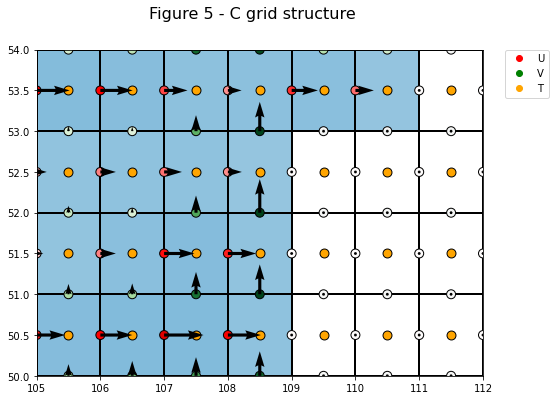

In [12]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Figure 5 - C grid structure', fontsize=16)
ax1=plt.axes()

ax1.set_xlim(105, 112)
ax1.set_ylim(50, 54)
ax1.pcolormesh(fx_corners,fy_corners,cudmask,cmap='Blues',edgecolors='k',linewidth=1)
ax1.scatter(xu_corners,yu_corners, s=80,c=cufields['uos'][0],cmap='seismic',vmin=-0.1,vmax=0.1,edgecolor='k', label = 'U')
ax1.scatter(xv_corners,yv_corners, s=80,c=cvfields['vos'][0],cmap='PRGn',vmin=-0.1,vmax=0.1,edgecolor='k', label = 'V')
ax1.scatter(cx_centers,cy_centers, s=80,c='orange',edgecolor='k', label = 'T')
ax1.quiver(xu_corners,yu_corners,cufields['uos'][0],np.zeros(xu_corners.shape),angles='xy', scale_units='xy', scale=0.1, width=0.007)
ax1.quiver(xv_corners,yv_corners,np.zeros(xv_corners.shape),cvfields['vos'][0],angles='xy', scale_units='xy', scale=0.3, width=0.007)

custom_lines = [Line2D([0], [0], marker='o', color='r',lw=0),
                Line2D([0], [0], marker='o', color='g', lw=0),
                Line2D([0], [0], marker='o', color='orange', lw=0)]

ax1.legend(custom_lines, ['U', 'V', 'T'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In **figure 5** you can see how a boundary can be traced along the cell edges, where the velocity is zero, because the _normal_ velocities are defined at the edges in a C-grid. This ensures that the most important boundary condition in many models is satisfied: the normal-component of velocity is zero at the boundary. Within a cell, Parcels interpolates the velocities on a C-grid linearly in the direction of that component and constant throughout a cell in the other directions. This means that the cross-boundary component is linearly interpolated to zero at the boundary and the along-boundary component is constant towards the boundary. Note that this is the same interpolation as used in the 'Analytical Advection' Scheme of e.g. TRACMASS and Ariane, see also [this tutorial](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_analyticaladvection.ipynb).

#### 2.1 Consistency with NEMO configuration
Here we look at how the lateral boundary conditions are implemented in NEMO. This is documented [here](https://www.nemo-ocean.eu/doc/node58.html). 

The cross-boundary component of velocity, defined at the cell faces where the boundary is defined, is set to zero at all boundaries. See the figure below. This corresponds exactly with the velocity field in a Parcels `FieldSet` shown in **figure 5**.

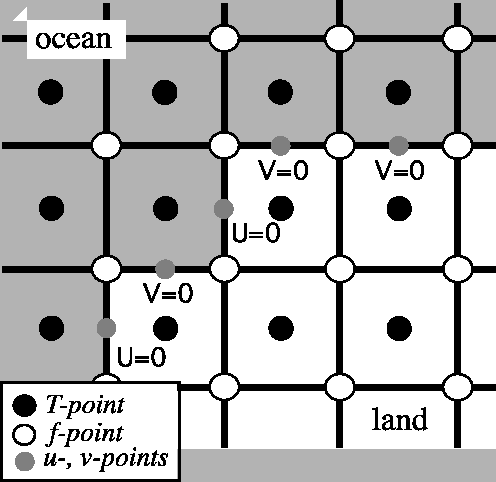

In [13]:
Image(filename='NEMO_latBC.png') 

There are different options for the along-boundary velocity in NEMO: a free-slip condition, a partial-slip condition and a no-slip condition. Since the tangential velocity is not defined at the boundary, this boundary condition is defined by a Neumann boundary condition: the normal derivative of the along-boundary velocity is specified. This derivative is schematically represented by a "ghost" velocity on the adjacent land node. The specified derivative is equivalent to what would result from the central difference between the along-boundary velocity at the nearest ocean cell and this "ghost" velocity. The type of boundary condition defines the direction and magnitude of this "ghost" velocity relative to the along-boundary velocity in the fluid domain. In Parcels, these "ghost" velocities may be used to determine how the velocity should be interpolated near the coast. By default, parcels interpolates piecewise-constant in the direction normal to the velocity component. This means that the along-boundary velocity is the same for any distance away from the boundary and therefore equivalent to the free-slip boundary condition shown in subfigure **(a)** below.

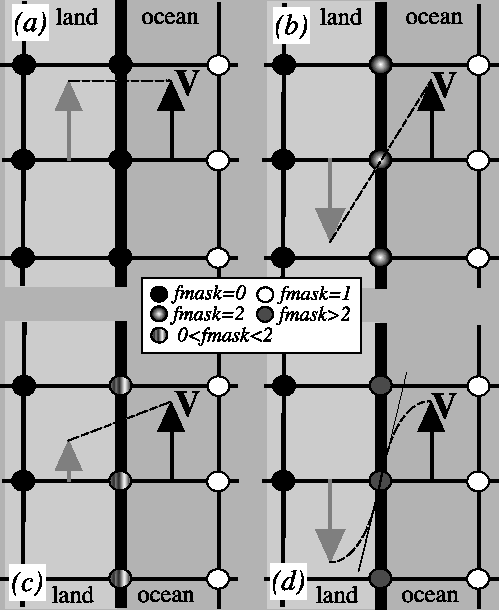

In [14]:
Image(filename='NEMO_ghost_vel.png')

#### 2.2 Particle trajectories near the boundary in a C grid
Now let's see how particles move near the boundary in a `FieldSet` derived from the mass-conserving NEMO C grid. 

In [15]:
data_path = 'NemoNorthSeaORCA025-N006_data/'
ufiles = sorted(glob(data_path+'ORCA*U.nc'))
vfiles = sorted(glob(data_path+'ORCA*V.nc'))
wfiles = sorted(glob(data_path+'ORCA*W.nc'))
mesh_mask = data_path + 'coordinates.nc'

coords = xr.open_dataset(mesh_mask, decode_times=False)

In [16]:
filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
         'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
         'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles}}

variables = {'U': 'uo',
             'V': 'vo',
             'W': 'wo'}
dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}}

fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

npart = 10  # number of particles to be released
lon = np.linspace(3 , 4, npart, dtype=np.float32)
lat = 51.5 * np.ones(npart)
time = np.zeros(npart)

pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon, lat=lat, time=time)

output_file = pset.ParticleFile(name="Cgrid-stuck.nc", outputdt=delta(hours=1))
pset.execute(AdvectionRK4, runtime=delta(days=10), dt=delta(minutes=5),
             output_file=output_file)
output_file.close()  # export the trajectory data to a netcdf file

         It will be opened with no decoding. Filling values might be wrongly parsed.
INFO: Compiled ArrayJITParticleAdvectionRK4 ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\lib6fa314727144c3c56926e8c7ac7ad9ec_0.dll


In [17]:
data_NEMO = xr.open_dataset('Cgrid-stuck.nc')

In [18]:
pdx = np.diff(data_NEMO['lon'],axis=1,prepend=0)
pdy = np.diff(data_NEMO['lat'],axis=1,prepend=0)
distance = np.sqrt(np.square(pdx)+np.square(pdy))
stuck = distance<(1e-5)

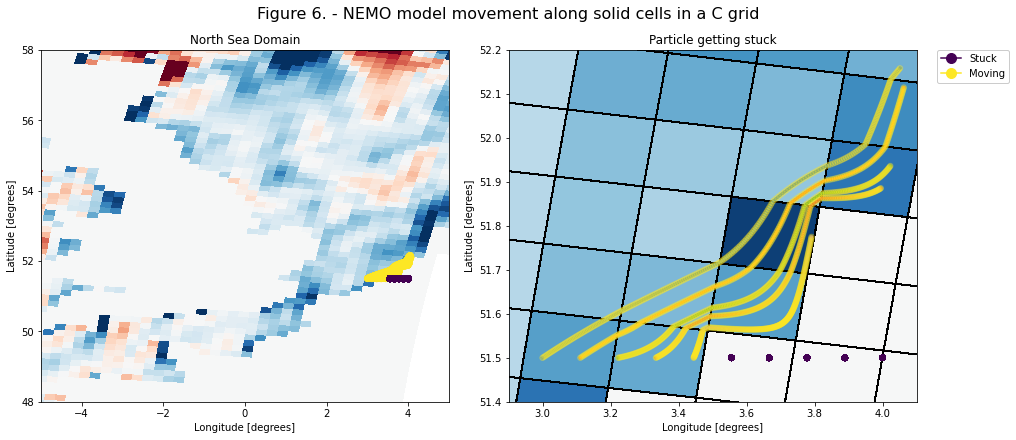

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6),constrained_layout=True)
fig.suptitle('Figure 6. - NEMO model movement along solid cells in a C grid', fontsize=16)

ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_title('North Sea Domain')
ax1.set_xlim(-5, 5)
ax1.set_ylim(48, 58)

ax1.pcolormesh(coords['glamf'][0],coords['gphif'][0],cvfields['vo'][0,0,1:,1:], cmap='RdBu', vmin=-0.1, vmax=0.1)
ax1.plot(data_NEMO['lon'].T, data_NEMO['lat'].T,linewidth=3,zorder=1)
ax1.scatter(data_NEMO['lon'], data_NEMO['lat'], c=stuck, cmap='viridis_r', zorder=2)

ax2.set_ylabel('Latitude [degrees]')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_title('Particle getting stuck')
ax2.set_xlim(2.9, 4.1)
ax2.set_ylim(51.4, 52.2)

ax2.pcolormesh(coords['glamf'][0],coords['gphif'][0],cvfields['vo'][0,0,1:,1:], cmap='RdBu', vmin=-0.1, vmax=0.1,edgecolors='k',linewidth=1)
ax2.plot(data_NEMO['lon'].T, data_NEMO['lat'].T,linewidth=3,zorder=1)
ax2.scatter(data_NEMO['lon'], data_NEMO['lat'], c= stuck, s=30, cmap='viridis_r', alpha=0.3, zorder=2)

color_stuck = copy(plt.get_cmap('viridis'))(0)
color_moving = copy(plt.get_cmap('viridis'))(256)
custom_lines = [Line2D([0], [0], c = color_stuck, marker='o', markersize=10),
                Line2D([0], [0], c = color_moving, marker='o', markersize=10)]
ax2.legend(custom_lines, ['Stuck', 'Moving'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,framealpha=1)
plt.show()

As we can see in **figure 6**, the particles that start in the ocean move along the boundary, since the cross-boundary component goes to zero, but the along-boundary component is equal to the value away from the coast.

**Figure 8** shows how the distance traveled does not go to zero as the particles move close to the model boundary, as the along-boundary component does not go to zero.

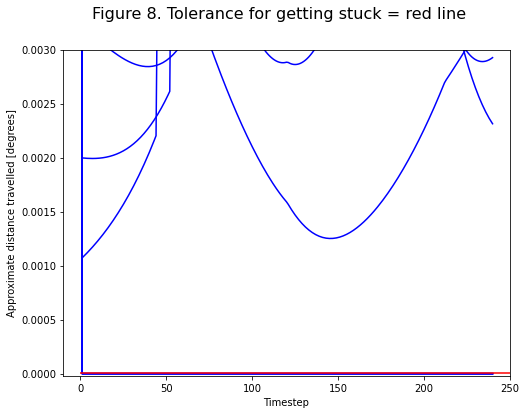

In [20]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Figure 8. Tolerance for getting stuck = red line', fontsize=16)
ax=plt.axes()

ax.plot(distance.T, color='b',zorder=1)
ax.hlines(1e-5,0,250, color='r',zorder=2)
ax.set_ylabel('Approximate distance travelled [degrees]')
ax.set_xlabel('Timestep')
ax.set_ylim(-0.00002,0.003)
ax.set_xlim(-10, 250)
plt.show()

### 3. B grids
On Arakawa B grids, $u$ and $v$ are at the same location, while $w$ and scalar variables like pressure are staggered. In 2 dimensional flow, Parcels therefore uses the same bilinear interpolation as for [A grids](#A-grids) to find the horizontal velocity, since the $u$ and $v$ components are similarly collocated. This can cause particles to get stuck in the same way as on A grids.

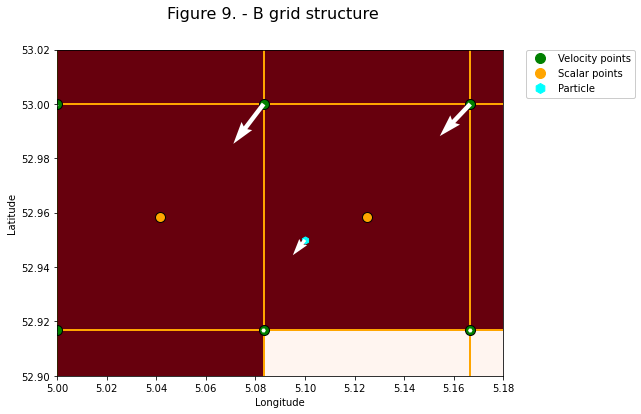

In [21]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Figure 9. - B grid structure', fontsize=16)
ax=plt.axes()

ax.set_xlim(5.0,5.18)
ax.set_ylim(52.9,53.02)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange')
ax.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=100,color='green',cmap='cmo.balance_r',vmin=-0.05,vmax=0.05,edgecolors='k')
ax.scatter(x_outcorners[latminx:latmaxx,lonminx:lonmaxx],y_outcorners[latminx:latmaxx,lonminx:lonmaxx],s=100,color='orange',cmap='cmo.balance_r',vmin=-0.05,vmax=0.05,edgecolors='k')
ax.quiver(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],SMOC_U,SMOC_V,angles='xy', scale_units='xy', scale=10, color='w',width=0.01)

plon = 5.1
plat = 52.95
pU = fu(plon,plat)
pV = fv(plon,plat)
ax.scatter(plon,plat,s=50, color='cyan',marker='h')
ax.quiver(plon,plat,pU,pV,angles='xy', scale_units='xy', scale=10, color='w')

custom_lines = [Line2D([0], [0], c='green', marker='o', markersize=10, lw=0),
                Line2D([0], [0], c='orange', marker='o', markersize=10, lw=0),
                Line2D([0], [0], c='cyan', marker='h', markersize=10, lw=0)]
ax.legend(custom_lines, ['Velocity points', 'Scalar points', 'Particle'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,framealpha=1)

### 4. Diffusion
In many parcels simulations other motions are added. Examples are Brownian motion from a diffusivity field and Stokes drift based on a wind field. These sources of motion will not necessarily consider the same boundaries and, unless they are also based on a C grid, they may also result in particles getting stuck on land. TO show how this happens, let us add a random walk to the advection in a C grid velocity field.

This random walk can be added using a diffusion kernel, as documented in [this notebook](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_diffusion.ipynb). Since the particles will move randomly through the domain, without awareness of the solid-fluid boundaries in the velocity field, we cannot define stuck particles as having moved less than a tolerance value and we will instead check whether particles find themselves on land or not. To do this, we sample a `landmask` field which denotes the f-nodes that are part of the solid.

In [22]:
from parcels import DiffusionUniformKh, Kernel

In [23]:
class LandParticle(JITParticle):
    on_land = Variable('on_land')
    
def Sample_land(particle, fieldset, time):
    particle.on_land = fieldset.landmask[time, particle.depth, particle.lat, particle.lon]

In [24]:
landmask = np.logical_or(np.ma.masked_equal(cufields['uo'][0, 0],0.).mask,
                         np.ma.masked_equal(cvfields['vo'][0, 0],0.).mask)

In [25]:
filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
         'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
         'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles}}

variables = {'U': 'uo',
             'V': 'vo',
             'W': 'wo'}
dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}}

fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

fieldset.add_constant_field('Kh_zonal', 5, mesh='spherical')
fieldset.add_constant_field('Kh_meridional', 5, mesh='spherical')
#     fieldset.add_constant('dres', 0.00005)
fieldset.add_field(Field('landmask',data=landmask,lon=coords['glamf'],lat=coords['gphif'],mesh='spherical'))

npart = 10  # number of particles to be released
lon = np.linspace(3 , 4, npart, dtype=np.float32)
lat = 51.5 * np.ones(npart)
time = np.zeros(npart)

pset = ParticleSet(fieldset=fieldset, pclass=LandParticle, lon=lon, lat=lat, time=time)

output_file = pset.ParticleFile(name="Cgrid-diffusion.nc", outputdt=delta(hours=1))
pset.execute(pset.Kernel(AdvectionRK4)+pset.Kernel(DiffusionUniformKh)+pset.Kernel(Sample_land), runtime=delta(days=10), dt=delta(minutes=5),
             output_file=output_file)
output_file.close()  # export the trajectory data to a netcdf file

INFO: Compiled ArrayLandParticleAdvectionRK4DiffusionUniformKhSample_land ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\lib3236ee6ec66e6f06c5f096559310d3a6_0.dll


In [26]:
data_diff = xr.open_dataset('Cgrid-diffusion.nc')

In [27]:
stuck = data_diff['on_land']==1

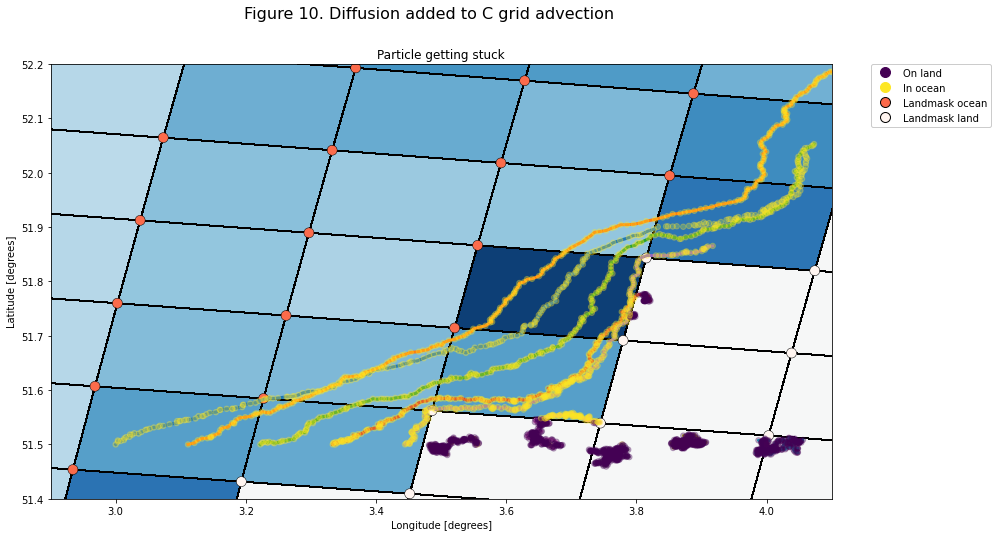

In [28]:
fig = plt.figure(figsize=(14,8))
fig.suptitle('Figure 10. Diffusion added to C grid advection', fontsize=16)
ax=plt.axes()

ax.set_ylabel('Latitude [degrees]')
ax.set_xlabel('Longitude [degrees]')
ax.set_title('Particle getting stuck')
ax.set_xlim(2.9, 4.1)
ax.set_ylim(51.4, 52.2)

ax.pcolormesh(coords['glamf'][0],coords['gphif'][0],cvfields['vo'][0,0,1:,1:], cmap='RdBu', vmin=-0.1, vmax=0.1,edgecolors='k',linewidth=1)
ax.plot(data_diff['lon'].T, data_diff['lat'].T,linewidth=3,zorder=1)
ax.scatter(data_diff['lon'], data_diff['lat'], c= stuck, s=30, cmap='viridis_r', alpha=0.3, zorder=2)
ax.scatter(coords['glamf'][0],coords['gphif'][0],c=landmask,cmap='Reds_r',s=100,edgecolors='k',vmin=-1,linewidth=0.5)

color_stuck = copy(plt.get_cmap('viridis'))(0)
color_moving = copy(plt.get_cmap('viridis'))(256)
color_land = copy(plt.get_cmap('Reds'))(0)
color_ocean = copy(plt.get_cmap('Reds'))(128)

custom_lines = [Line2D([0], [0], c = color_stuck, marker='o', markersize=10, lw=0),
                Line2D([0], [0], c = color_moving, marker='o', markersize=10, lw=0),
                Line2D([0], [0], c = color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax.legend(custom_lines, ['On land', 'In ocean', 'Landmask ocean', 'Landmask land'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,framealpha=1)
plt.show()

In [29]:
data_diff.close()

**Figure 10** shows why you should consider additional boundary conditions for each component of the motion added to the particle.